In [27]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
import easyocr

# Inicializar EasyOCR una sola vez (en inglés)
reader = easyocr.Reader(['en'], gpu=False)  # gpu=True si tienes GPU NVIDIA

matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)

images_path = './Images/'
images_path_english = './Images/English/'
images_path_japanese = './Images/Japanese/'


Using CPU. Note: This module is much faster with a GPU.


In [11]:
def contorno_toca_borde(contorno, w, h, margen=10):
    pts = contorno.reshape(-1, 2)
    if (
        np.any(pts[:, 0] <= margen) or
        np.any(pts[:, 1] <= margen) or
        np.any(pts[:, 0] >= w - margen) or
        np.any(pts[:, 1] >= h - margen)
    ):
        return True
    return False

def ordenar_puntos(pts):
    """Ordenar puntos: [top-left, top-right, bottom-right, bottom-left]"""
    pts = np.array(pts, dtype=np.float32)
    
    # Ordenar por X
    sorted_x = pts[np.argsort(pts[:, 0])]
    
    # Dividir: izquierda (2 primeros) y derecha (2 últimos)
    izq = sorted_x[:2]
    der = sorted_x[2:]
    
    # Ordenar cada lado por Y (arriba → abajo)
    izq = izq[np.argsort(izq[:, 1])]
    der = der[np.argsort(der[:, 1])]
    
    # Devolver en orden: tl, tr, br, bl
    return np.array([izq[0], der[0], der[1], izq[1]], dtype=np.float32)


def rectificar_carta(img_color, pts_src, ancho_dest=720):
    """Versión simplificada con ordenamiento correcto"""
    alto_dest = int(ancho_dest / 0.715)
    
    # Ordenamos los puntos antes de la homografía
    pts_src = ordenar_puntos(pts_src)
    
    # Puntos destino en el MISMO orden
    pts_dst = np.float32([
        [0, 0],                  # top-left
        [ancho_dest, 0],         # top-right
        [ancho_dest, alto_dest], # bottom-right
        [0, alto_dest]           # bottom-left
    ])
    
    # Calcular homografía y rectificar
    M = cv2.getPerspectiveTransform(pts_src, pts_dst)
    warped = cv2.warpPerspective(img_color, M, (ancho_dest, alto_dest))
    
    return warped


In [29]:
# ------------------------------------------------------------
# 1. Cargar y preprocesar
# ------------------------------------------------------------
def cargar_y_preprocesar(ruta_img, ancho_max=1280):
    img = cv2.imread(ruta_img)
    if img is None:
        raise ValueError("No se pudo leer la imagen. Revisa la ruta.")

	# Ponemos un ancho común y hacemos que el alto se ajuste
    height, width = img.shape[:2]
    if width > ancho_max:
        escalawidth = ancho_max / width
        nuevoheight = int(height * escalawidth)
        img = cv2.resize(img, (ancho_max, nuevoheight))

    # Convertir a escala de grises
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Aplicar desenfoque bilateral para reducir ruido manteniendo bordes
    img_blur = cv2.bilateralFilter(img_gray, 11, 17, 17)
    
    # Usar umbralización adaptativa para mejorar contraste (para Hough)
    th = cv2.adaptiveThreshold(
        img_gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        15, 5
    )
    
    # Uso Canny con umbrales más bajos para detectar más bordes
    edges = cv2.Canny(img_blur, 30, 100)

    # Dilato los bordes para unirlos
    kernel = np.ones((5, 5), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)

    return img, edges, th, img_gray


def encontrar_carta_como_quad(edges):
    h, w = edges.shape[:2]
    area_imagen = h * w

    cnts, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    candidatos = []
    for c in cnts:
        area = cv2.contourArea(c)
        area_minima = area_imagen * 0.15
        area_maxima = area_imagen * 0.90
        
        if area < area_minima or area > area_maxima:
            continue

		# Si el contorno toca los bordes de la imagen, lo descartamos
        if contorno_toca_borde(c, w, h, margen=25):
            continue

        # Aproximar el contorno a un polígono
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        
        # Preferir cuadriláteros, pero aceptar otros si tienen área suficiente
        if len(approx) >= 4:
            # Calculamos el rectángulo mínimo que encierra el contorno
            rect = cv2.minAreaRect(c)
            
            # Descartamos líneas
            (wr, hr) = rect[1]
            if wr == 0 or hr == 0:
                continue
            
            # Calcular el aspect ratio (debería estar cerca de 0.715 para cartas TCG)
            aspect_ratio = min(wr, hr) / max(wr, hr)
            
            # Aceptar ratios entre 0.5
            if aspect_ratio < 0.5:
                continue
            
            # Calcular qué tan "lleno" está el contorno (área vs rectángulo)
            rect_area = wr * hr
            extent = area / rect_area if rect_area > 0 else 0
            
            # Una carta debería tener extent > 0.6 (es bastante rectangular)
            if extent < 0.6:
                continue
            
            candidatos.append((area, rect, approx))

    if not candidatos:
        return None

	# Busco el rectángulo con mayor área
    candidatos.sort(key=lambda x: x[0], reverse=True)
    
	# Retorno las coordenadas del rectángulo (usando approx si tiene 4 puntos, sino box)
    area, rect, approx = candidatos[0]
    
    if len(approx) == 4:
        return approx.reshape(4, 2)
    else:
        box = cv2.boxPoints(rect)
        return box.reshape(4, 2)

# ------------------------------------------------------------
# Ordenar y rectificar
# ------------------------------------------------------------

def metodo_adaptativo_rect(th):
    kernel = np.ones((3, 3), np.uint8)
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=2)

    h, w = th.shape[:2]
    area_img = h * w
    cnts, _ = cv2.findContours(th, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    candidatos = []
    for c in cnts:
        area = cv2.contourArea(c)
        area_minima = area_img * 0.10
        area_maxima = area_img * 0.90
        
        if area < area_minima or area > area_maxima:
            continue
        
        if contorno_toca_borde(c, w, h, margen=10):
            continue

        rect = cv2.minAreaRect(c)
        (wr, hr) = rect[1]
        if wr == 0 or hr == 0:
            continue

        aspect_ratio = min(wr, hr) / max(wr, hr)
        if not (0.63 <= aspect_ratio <= 0.78):
            continue

        candidatos.append((area, rect))

    if not candidatos:
        return None

    candidatos.sort(key=lambda x: x[0], reverse=True)
    _, rect = candidatos[0]
    box = cv2.boxPoints(rect)
    return box.reshape(4, 2)


def metodo_hough_rectas(img_color, canny1=50, canny2=150, min_line_len=80, max_line_gap=10):
    """
    Intenta detectar la carta buscando 4 lados casi rectos con Hough.
    Devuelve 4 puntos en el orden: tl, tr, br, bl o None.
    """
    h, w = img_color.shape[:2]

    gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(gray, canny1, canny2)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=80,
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    if lines is None:
        return None

    verticales = []
    horizontales = []

    for l in lines:
        x1, y1, x2, y2 = l[0]
        if x2 == x1 and abs(y2 - y1) > 20:
            verticales.append((x1, y1, x2, y2))
        else:
            m = (y2 - y1) / (x2 - x1 + 1e-6)
            if abs(m) < 0.2:  # casi horizontal
                horizontales.append((x1, y1, x2, y2))
            elif abs(m) > 5:  # casi vertical pero no x2==x1
                verticales.append((x1, y1, x2, y2))

    if len(verticales) < 1 or len(horizontales) < 1:
        return None

    # extremos
    xs = [min(v[0], v[2]) for v in verticales] + [max(v[0], v[2]) for v in verticales]
    ys = [min(hh[1], hh[3]) for hh in horizontales] + [max(hh[1], hh[3]) for hh in horizontales]

    x_min = max(0, min(xs))
    x_max = min(w - 1, max(xs))
    y_min = max(0, min(ys))
    y_max = min(h - 1, max(ys))

    # filtramos rectángulos raros
    ancho = x_max - x_min
    alto = y_max - y_min
    if ancho < w * 0.1 or alto < h * 0.1:
        return None

    ar = min(ancho, alto) / max(ancho, alto)
    if not (0.55 <= ar <= 0.85):
        # ratio demasiado raro para una carta típica
        return None

    quad = np.array([
        [x_min, y_min],  # tl
        [x_max, y_min],  # tr
        [x_max, y_max],  # br
        [x_min, y_max],  # bl
    ], dtype=np.float32)

    return quad




In [30]:
def dibujar_rois_carta(carta_rectificada):
    """Dibuja rectángulos verdes sobre los ROIs en la carta"""
    h, w = carta_rectificada.shape[:2]
    img_con_rois = carta_rectificada.copy()
    
    # Coordenadas de cada ROI (nombre, hp, numero)
    rois_coords = {
        "name": (int(0. * w), int(0.0 * h), int(0.65 * w), int(0.12 * h)),
        "hp": (int(0.68 * w), int(0.0 * h), int(1 * w), int(0.12 * h)),
        "numero": (int(0.01 * w), int(0.9 * h), int(0.35 * w), int(1 * h))
    }
    
    # Dibujar cada ROI con línea verde
    for nombre, (x1, y1, x2, y2) in rois_coords.items():
        cv2.rectangle(img_con_rois, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # Añadir etiqueta
        cv2.putText(img_con_rois, nombre, (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return img_con_rois

def extraer_rois_carta(carta_rectificada):
    """Extrae las regiones donde está el nombre, HP y número"""
    h, w = carta_rectificada.shape[:2]
    
    # Región del NOMBRE (arriba izquierda)
    name_roi = carta_rectificada[
        int(0.0 * h) : int(0.12 * h),  # Y: 2% al 5.5% altura (más centrado)
        int(0. * w) : int(0.65 * w)     # X: 6% al 50% ancho (más amplio)
    ]
    
    # Región del HP (arriba derecha) - Ajustada para capturar solo los números
    hp_roi = carta_rectificada[
        int(0.0 * h) : int(0.12 * h),  # Y: 5.5% al 9.5% altura (igual que nombre)
        int(0.68 * w) : int(1 * w)     # X: 68% al 90% ancho (más ajustado)
    ]
    
    # Región del NÚMERO (abajo derecha, esquina)
    numero_roi = carta_rectificada[
        int(0.9 * h) : int(1 * h),  # Y: 93% al 99% altura
        int(0.01 * w) : int(0.35 * w)   # X: 75% al 95% ancho
    ]
    
    return {
        "name": name_roi,
        "hp": hp_roi,
        "numero": numero_roi
    }



In [31]:


def aplicar_ocr_carta(carta_rectificada):
    """Aplica OCR a las regiones de interés de la carta"""
    # Extraer las ROIs
    rois = extraer_rois_carta(carta_rectificada)
    
    resultados = {}
    
    # Aplicar OCR a cada ROI
    for nombre_roi, roi in rois.items():
        try:
            # EasyOCR espera la imagen en formato RGB si es color
            if len(roi.shape) == 3:
                roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
            else:
                roi_rgb = roi
            
            # Aplicar OCR
            resultado = reader.readtext(roi_rgb, detail=0)
            
            # Unir todos los textos detectados
            texto = ' '.join(resultado) if resultado else ""
            resultados[nombre_roi] = texto
            
        except Exception as e:
            print(f"Error en OCR de {nombre_roi}: {e}")
            resultados[nombre_roi] = ""
    
    return resultados

In [48]:
import json
from difflib import get_close_matches



def al_menos_n_letras(objetivo: str, candidato: str, n: int) -> bool:
    objetivo = objetivo.lower()
    candidato = candidato.lower()

    comunes = set(objetivo) & set(candidato)
    return len(comunes) >= n

def limpiar_basico(texto: str) -> str:
    palabras = texto.split()
    if palabras and al_menos_n_letras("basico", palabras[0], 4):
        palabras = palabras[1:]
    return " ".join(palabras).strip()

def buscar_mas_parecido(nombre: str, lista: list[str], cutoff: float = 0.6) -> str | None:
    nombre = nombre.lower()
    candidatos = [n for n in lista if isinstance(n, str)]
    matches = get_close_matches(nombre, candidatos, n=1, cutoff=cutoff)
    return matches[0] if matches else None

def parsearNombre(texto: str) -> str:
    """Limpia el texto del nombre de la carta"""
    if not texto:
        return ""

    # 1) limpiar "basico"
    nombre = limpiar_basico(texto)

    # 2) cargar lista de cartas
    with open("./Scrapper/card_names_spanish.json", "r", encoding="utf-8") as f:
        cartas = json.load(f)

    # 3) buscar la más parecida
    mejor = buscar_mas_parecido(nombre, cartas, cutoff=0.55)
    return mejor if mejor else nombre


def parsearHP(texto: str) -> str:
    """Extrae solo los números del HP"""
    if not texto:
        return ""

    # Buscar números en el texto
    import re
    numeros = re.findall(r'\d+', texto)
    
    if numeros[0]:
        texto = numeros[0]
        texto = texto.strip()
        texto = texto.replace("O", "0").replace("o", "0")
    
	# Limpiar caracteres no numéricos o distintos de 0
        while texto and (texto[-1] != '0'):
            texto = texto[:-1]

        while texto and (texto[0] == '0'):
            texto = texto[1:]
            
        # Cojo los 3 ultimos dígitos (por si hay errores)
        if len(texto) > 3:
            texto = texto[-3:]

    return texto if texto else ""


import re

def parsearNumero(texto: str) -> str:
    """
    Extrae el número de carta en formato NN/N, NNN/NNN, etc.
    Ejemplos válidos:
      "025/165" -> "025/165"
      "1/73 e"  -> "1/73"
      "illus: PLANETA 001/073 e" -> "001/073"
      "1667086" -> "167/086" (detecta 7 dígitos con un 7 en medio)
    Si no encuentra nada así, devuelve "".
    """
    if not texto:
        return ""

    texto = texto.strip()
    
    # CASO ESPECIAL: detectar 7 dígitos consecutivos donde el del medio (posición 3) es un 7
    # Esto maneja el caso donde la barra "/" fue mal leída como "7"
    m_seven = re.search(r'(\d{3})7(\d{3})', texto)
    if m_seven:
        left = m_seven.group(1)
        right = m_seven.group(2)
        return f"{left}/{right}"

    # buscar patrón numero/numero (con espacios opcionales alrededor de /)
    m = re.search(r'(\d{1,4})\s*/\s*(\d{1,4})', texto)
    if not m:
        return ""

    # reconstruimos limpio con barra centrada
    left = m.group(1)
    right = m.group(2)
    return f"{left}/{right}"



def parsear_texto_ocr(datos_ocr):
    """Parsea los datos del OCR y devuelve un diccionario limpio"""
    return {
        "name": parsearNombre(datos_ocr.get("name", "")),
        "hp": parsearHP(datos_ocr.get("hp", "")),
        "numero": parsearNumero(datos_ocr.get("numero", ""))
    }


def imprimir_ocr_carta(index, datos_ocr):
    """Imprime los resultados del OCR de forma legible"""
    print(f"\n=== Carta {index} ===")
    datos_limpios = parsear_texto_ocr(datos_ocr)
    print(f"  Nombre: {datos_limpios['name']}")
    print(f"  HP: {datos_limpios['hp']}")
    print(f"  Número: {datos_limpios['numero']}")
    print(f"  [RAW - Name: '{datos_ocr.get('name', '')}']")
    print(f"  [RAW - HP: '{datos_ocr.get('hp', '')}']")
    print(f"  [RAW - Numero: '{datos_ocr.get('numero', '')}']")


In [33]:
import requests

def variantes_local_id(num_str: str) -> list[str]:
    s = str(num_str)
    resultados = []

    # quitamos ceros de la izquierda paso a paso
    sin_1 = s.lstrip('0')
    if sin_1:  # por si fuera "000"
        resultados.append(sin_1)

    # si el original tenía un cero delante, añadimos la versión con 1 cero
    if s[0] == '0':
        resultados.append(s.lstrip('0')[0:].rjust(len(s.lstrip('0')) + 1, '0'))
    
    # y siempre añadimos el original
    if s not in resultados:
        resultados.append(s)

    resultados = sorted(set(resultados), key=len)
    return resultados


def getOriginalUrl(cardName: str, cardHp: str, cardNumber: str) -> str:
    """Devuelve la URL original de la carta en tcgdex si es posible"""
    if not cardName or not cardNumber or not cardHp:
        return ""

    cardNumberList = cardNumber.split("/")
    # por si te viene "013/015"
    left_num = cardNumberList[0]
    right_num = cardNumberList[1] if len(cardNumberList) > 1 else None

    cardNumberId = variantes_local_id(left_num)
    
    base_url = "https://api.tcgdex.net/v2/en/cards/"
    firstHint = f"{base_url}?name={cardName}"

    r = requests.get(firstHint, timeout=15)
    r.raise_for_status()
    cards = r.json()

    finalUrl = ""

    if cards:
        # 1) filtro por localId
        cards = [c for c in cards if c.get("localId") in cardNumberId]

        # 2) saco los ids concretos
        sets = [carta["id"] for carta in cards if "id" in carta]
        secondHint = [f"{base_url}{set_id}" for set_id in sets]

        cartasDescargadas = []

        # descargo todas una vez
        for url in secondHint:
            try:
                r = requests.get(url, timeout=15)
                r.raise_for_status()
                carta = r.json()
                cartasDescargadas.append((carta, url))
            except Exception:
                # si alguna falla, la ignoramos
                continue

        # PRIMERO: por total de cartas del set
        if right_num is not None:
            for carta, url in cartasDescargadas:
                try:
                    totalCards = carta.get("set", {}).get("cardCount", {}).get("official")
                    if totalCards is None:
                        continue
                    if int(totalCards) == int(right_num):
                        finalUrl = url
                        print(f"URL final encontrada por numero total de cartas: {finalUrl}")
                        break
                except Exception:
                    # cualquier cosa rara la saltamos
                    continue

        # SEGUNDO: por HP si no lo encontramos antes
        if not finalUrl:
            for carta, url in cartasDescargadas:
                try:
                    hp = carta.get("hp")
                    if hp is None:
                        continue
                    if int(hp) == int(cardHp):
                        finalUrl = url
                        print(f"URL final encontrada por HP: {finalUrl}")
                        break
                except Exception:
                    continue

    return finalUrl


Método adaptativo encontró carta:  1

=== Carta 1 ===
  Nombre: 
  HP: 
  Número: 
  [RAW - Name: '']
  [RAW - HP: '']
  [RAW - Numero: 'N"MC']
Contorno encontrado:  2

=== Carta 1 ===
  Nombre: 
  HP: 
  Número: 
  [RAW - Name: '']
  [RAW - HP: '']
  [RAW - Numero: 'N"MC']
Contorno encontrado:  2

=== Carta 2 ===
  Nombre: Zekrom
  HP: 230
  Número: 158/086
  [RAW - Name: 'BAsigo Zekrom€']
  [RAW - HP: '5230']
  [RAW - Numero: 'Ilus Duts] 158/086 tolurea']

=== Carta 2 ===
  Nombre: Zekrom
  HP: 230
  Número: 158/086
  [RAW - Name: 'BAsigo Zekrom€']
  [RAW - HP: '5230']
  [RAW - Numero: 'Ilus Duts] 158/086 tolurea']
URL final encontrada por numero total de cartas: https://api.tcgdex.net/v2/en/cards/sv10.5b-158
Contorno encontrado:  3
URL final encontrada por numero total de cartas: https://api.tcgdex.net/v2/en/cards/sv10.5b-158
Contorno encontrado:  3

=== Carta 3 ===
  Nombre: Venusaur
  HP: 220
  Número: 001/073
  [RAW - Name: 'BASIC Venusaur']
  [RAW - HP: 'MP 220'']
  [RAW - Numer

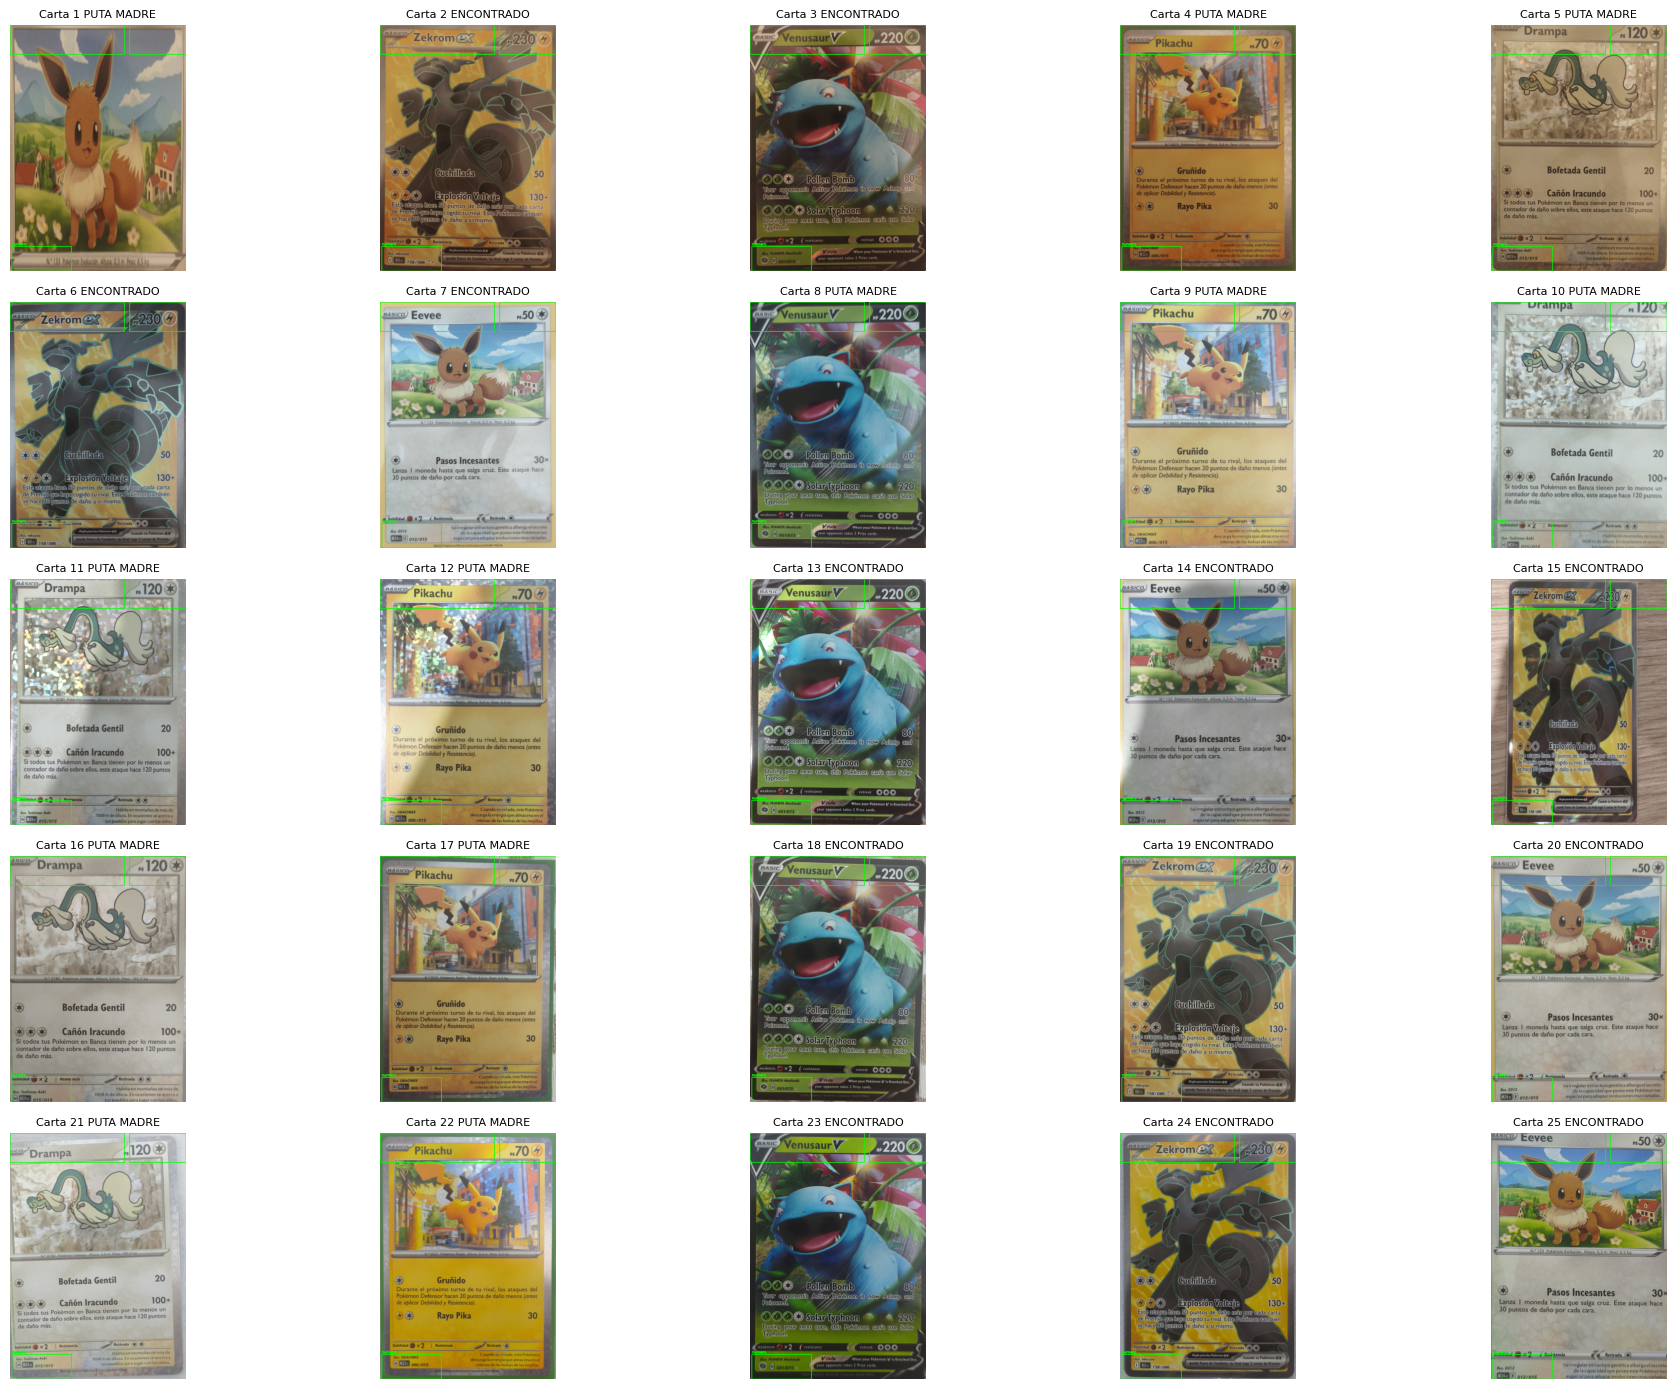

In [34]:
import requests

def cargarYDibujarContornos(index):
    ruta = images_path + "/Final/" + "Final_" + str(index) + ".jpg"
    numContorno, numAdaptativo, numHough = 0,0,0

    img_color, edges, th, img_gray = cargar_y_preprocesar(ruta)

    # 2) detección por contornos
    quad_cnt = encontrar_carta_como_quad(edges)
    if quad_cnt is not None:
        print("Contorno encontrado: ", index)
        numContorno += 1

    if quad_cnt is None:
		# Intentar método adaptativo
        quad_cnt = metodo_adaptativo_rect(th)
        if quad_cnt is not None:	print("Método adaptativo encontró carta: ", index)
        numAdaptativo += 1
        
    if quad_cnt is None:
		# Intentar método adaptativo
        quad_cnt = metodo_hough_rectas(img_color)
        if quad_cnt is not None:	print("Método hough encontró carta: ", index)
        numHough += 1
    
    img_cnt = img_color.copy()
    if quad_cnt is not None:
        cv2.polylines(img_cnt, [quad_cnt.astype(int)], True, (255, 0, 0), 3)
    else:
        cv2.putText(img_cnt, "Contornos no encontro carta", (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)
        
    return img_cnt, quad_cnt, img_color, numContorno, numAdaptativo, numHough

# Crear una figura grande con todas las imágenes en matriz
num_imagenes = 25
filas = 5
columnas = 5
contorno, adaptativo, hough = 0, 0, 0

plt.figure(figsize=(20, 14))  # Tamaño grande para ver bien todas las cartas

for i in range(1, num_imagenes + 1):
    img_contornos, quad_cnt, img_color, numContorno, numAdaptativo, numHough = cargarYDibujarContornos(i)
    
    contorno += numContorno
    adaptativo += numAdaptativo
    hough += numHough

    # Solo rectificar si encontramos contorno
    
    if quad_cnt is not None:
        img_contornos = rectificar_carta(img_color, quad_cnt)
        img_con_roid = dibujar_rois_carta(img_contornos)
        
        # Aplicar OCR y mostrar resultados
        datos_ocr = aplicar_ocr_carta(img_contornos)
        datos_limpios = parsear_texto_ocr(datos_ocr)

        imprimir_ocr_carta(i, datos_ocr)

        texto = getOriginalUrl(datos_limpios['name'], datos_limpios['hp'], datos_limpios['numero'])
        

    plt.subplot(filas, columnas, i)
    plt.imshow(cv2.cvtColor(img_con_roid, cv2.COLOR_BGR2RGB))
    plt.title(f"Carta {i} {"ENCONTRADO" if texto else 'PUTA MADRE'}", fontsize=8)
    plt.axis('off')

print("Intentos - Contorno:", contorno, " Adaptativo:", adaptativo, " Hough:", hough)


plt.tight_layout()  # Ajusta el espaciado entre imágenes
plt.show()

Contorno encontrado:  3

=== Carta 3 ===
  Nombre: Venusaur
  HP: 220
  Número: 001/073
  [RAW - Name: 'BASIC Venusaur']
  [RAW - HP: 'MP 220'']
  [RAW - Numero: 'ALANETA Mochiruki 001/073']
URL final encontrada por HP: https://api.tcgdex.net/v2/en/cards/swsh3.5-1


<Figure size 2000x1400 with 0 Axes>

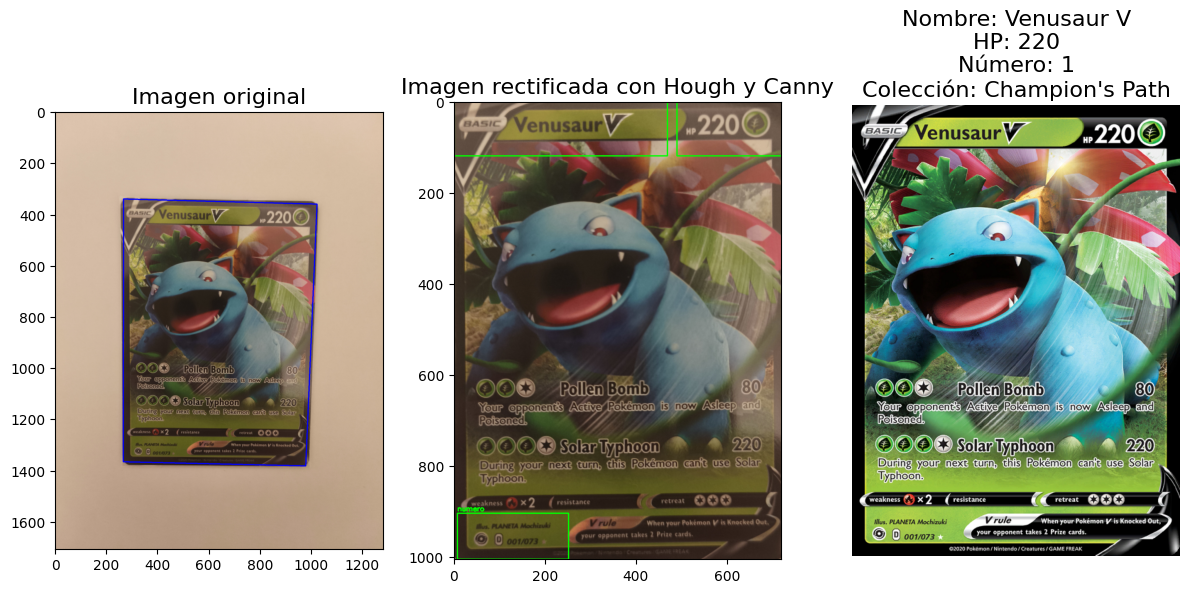

In [48]:
import requests

def cargarYDibujarContornos(index):
    ruta = images_path + "/Final/" + "Final_" + str(index) + ".jpg"

    img_color, edges, th, _ = cargar_y_preprocesar(ruta)

    # 2) detección por contornos
    quad_cnt = encontrar_carta_como_quad(edges)
    if quad_cnt is not None:
        print("Contorno encontrado: ", index)

    if quad_cnt is None:
		# Intentar método adaptativo
        quad_cnt = metodo_adaptativo_rect(th)
        if quad_cnt is not None:	print("Método adaptativo encontró carta: ", index)
        
    if quad_cnt is None:
		# Intentar método adaptativo
        quad_cnt = metodo_hough_rectas(img_color)
        if quad_cnt is not None:	print("Método hough encontró carta: ", index)
    
    img_cnt = img_color.copy()
    if quad_cnt is not None:
        cv2.polylines(img_cnt, [quad_cnt.astype(int)], True, (255, 0, 0), 3)
    else:
        cv2.putText(img_cnt, "Contornos no encontro carta", (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)
        
    return img_cnt, quad_cnt, img_color



plt.figure(figsize=(20, 14))  # Tamaño grande para ver bien todas las cartas

img_contornos, quad_cnt, img_color = cargarYDibujarContornos(3)
    
img_original = img_contornos.copy()

img_contornos = rectificar_carta(img_color, quad_cnt)
img_con_roid = dibujar_rois_carta(img_contornos)
        
        # Aplicar OCR y mostrar resultados
datos_ocr = aplicar_ocr_carta(img_contornos)
datos_limpios = parsear_texto_ocr(datos_ocr)

imprimir_ocr_carta(3, datos_ocr)

url = getOriginalUrl(datos_limpios['name'], datos_limpios['hp'], datos_limpios['numero'])

r = requests.get(url, timeout=15)
r.raise_for_status()
carta = r.json()

nombre = carta.get("name", "Desconocido")
hp = carta.get("hp", "Desconocido")
numero = carta.get("localId", "Desconocido")
coleccion = carta.get("set", {}).get("name", "Desconocido")
img = requests.get(f"{carta['image']}/high.jpg")
img_data = np.frombuffer(img.content, np.uint8)
img_web = cv2.imdecode(img_data, cv2.IMREAD_COLOR)


plt.figure(figsize=(12, 6))  # Tamaño adecuado para dos imágenes lado a lado
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
plt.title(f"Imagen original", fontsize=16)
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(img_con_roid, cv2.COLOR_BGR2RGB))
plt.title(f"Imagen rectificada con Hough y Canny", fontsize=16)
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(img_web, cv2.COLOR_BGR2RGB))
plt.title(f"Nombre: {nombre}\nHP: {hp}\nNúmero: {numero}\nColección: {coleccion}", fontsize=16)
plt.axis('off')

plt.tight_layout()  # Ajusta el espaciado entre imágenes
plt.show()